In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.av_dataset import Dataset
from rulevetting.projects.csi_pecarn.tree_functions import *

from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

avdf_all = Dataset().get_data(use_robust_av = False)
avdf_ran = Dataset().get_data(use_robust_av = False, control_types=['ran'])
avdf_moi = Dataset().get_data(use_robust_av = False, control_types=['moi'])
avdf_ems = Dataset().get_data(use_robust_av = False, control_types=['ems'])

/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting


/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


## Control group: random

In [2]:
# control group: random
data_list = avdf_all
data_train = data_list[0]
data_tuning = data_list[1]

X = data_train.loc[:,'AlteredMentalStatus':'NonAmbulatory']
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.loc[:,'AlteredMentalStatus':'NonAmbulatory']
y_tuning = data_tuning['csi_injury'].astype('int')

#### Leonard et al(2011)

In [3]:
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'SubInj_TorsoTrunk','Predisposed','HighriskDiving','HighriskMVC']
Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation

[0.9166666666666666, 0.40124740124740127]

In [4]:
Leo_evaluation2 = evaluate_vlist(data_train, Leonard)

### Decision trees

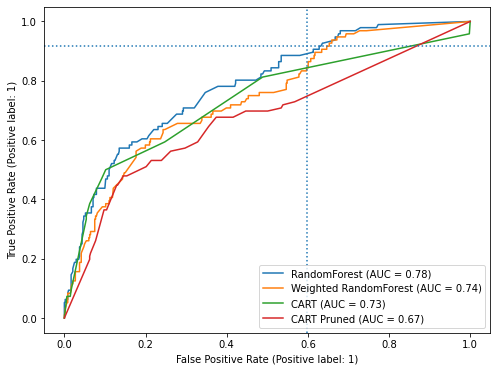

In [5]:
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)

cart_small = tree.DecisionTreeClassifier(max_depth = 5,random_state = 1)
cart_small = cart_small.fit(X,y)

rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

rf_weighted = RandomForestClassifier(class_weight = {1:10, 0:1},random_state = 1)
rf_weighted = rf_weighted.fit(X,y)

fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(rf_weighted, X_tuning, y_tuning, ax=ax, name = "Weighted RandomForest")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART Pruned")

ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":")

plt.show()

## Simple Tree

In [15]:
data = data_train
v_list = list(data.columns)
v_list.remove('csi_injury')
variable_rank = []
while len(v_list) > 0:
    result = find_best_two(data,v_list,method = "semi_gini")
    # result = find_best(data,v_list,method = "semi_gini")
    variable_rank.append(result[0])
    v_list = result[1]
    data = result[2]

variable_rank

[['HighriskDiving', 'no need'],
 ['Clotheslining', 'no need'],
 ['FocalNeuroFindings', 'no need'],
 ['Predisposed', 'no need'],
 ['Torticollis', 'no need'],
 ['SubInj_TorsoTrunk', 'NonAmbulatory'],
 ['AlteredMentalStatus', 'no need'],
 ['axialloadtop', 'no need'],
 ['HighriskMVC', 'NonAmbulatory'],
 ['PainNeck', 'no need'],
 ['PosMidNeckTenderness', 'HighriskFall'],
 ['TenderNeck', 'NonAmbulatory'],
 ['SubInj_Head', 'HighriskHanging'],
 ['AxialLoadAnyDoc', 'HighriskHanging'],
 ['HighriskFall', 'SubInj_Ext'],
 ['NonAmbulatory', 'HighriskHanging'],
 ['LOC', 'SubInj_Face'],
 ['HighriskHanging', 'no observations'],
 ['SubInj_Face', 'SubInj_Ext'],
 ['SubInj_Ext', 'HighriskHitByCar'],
 ['HighriskHitByCar', 'HighriskOtherMV'],
 ['HighriskOtherMV', 'no variable']]

In [16]:
v_list = variable_rank
data = data_train
l = len(v_list)
ind = range(l)
TPR = [0]*l
FPR = [0]*l
for i in ind:
    r = evaluate_vlist(data,v_list[0:i], method = 'two')
    TPR[i] = r[0]
    FPR[i] = 1- r[1]
d = {'num': ind, 'TPR': TPR, 'FPR': FPR}
evaluation_train = pd.DataFrame(data = d)

data = data_tuning
l = len(v_list)
ind = range(l)
TPR = [0]*l
FPR = [0]*l
for i in ind:
    r = evaluate_vlist(data,v_list[0:i], method = 'two')
    TPR[i] = r[0]
    FPR[i] = 1- r[1]
d = {'num': ind, 'TPR': TPR, 'FPR': FPR}
evaluation_tuning = pd.DataFrame(data = d)

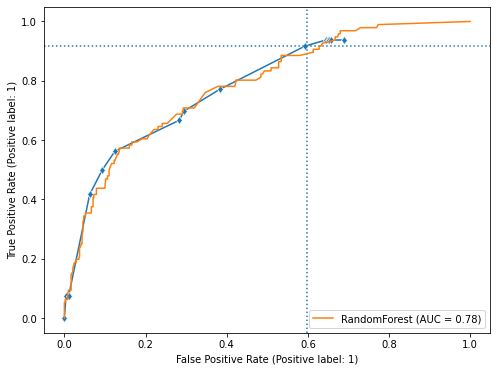

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
# sns.lineplot(x='FPR', y= 'TPR', data = evaluation_train, marker='o')
sns.lineplot(x='FPR', y= 'TPR', data = evaluation_tuning, marker='d')
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":")
# ax.axhline(Leo_evaluation2[0],linestyle = ":", color = "red")
# ax.axvline(1-Leo_evaluation2[1],linestyle = ":", color = "red")
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()